# Backpropagation using MINST dataset

In [1]:
import torch
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST

In [2]:
# you can go to Edit - Notebook settings to select GPU under the Hardware accelerator
# check the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
# build the dataset (train, validation and test)
def load_MNIST(n_val=10000, n_sample=1000, sample=False):
    n_val = n_val
    n_sample = n_sample
    train = MNIST(root = '.', train = True, download = True)
    test = MNIST(root = '.', train = False, download = True)
    
    # data preprocessing
    x_train, x_test = train.data/255, test.data/255
    x_train = x_train.reshape(x_train.shape[0], -1)
    x_test = x_test.reshape(x_test.shape[0], -1)
    y_train = torch.nn.functional.one_hot(train.targets)
    y_test = torch.nn.functional.one_hot(test.targets)

    data_dict = {}
    if sample:
        data_dict['x_train'] = x_train[:-n_val][:n_sample]
        data_dict['y_train'] = y_train[:-n_val][:n_sample]
        data_dict['x_val'] = x_train[-n_val:][:n_sample//10]
        data_dict['y_val'] = y_train[-n_val:][:n_sample//10]
        data_dict['x_test'] = x_test[:n_sample//10]
        data_dict['y_test'] = y_test[:n_sample//10]
    else:
        data_dict['x_train'] = x_train[:-n_val]
        data_dict['y_train'] = y_train[:-n_val]
        data_dict['x_val'] = x_train[-n_val:]
        data_dict['y_val'] = y_train[-n_val:]
        data_dict['x_test'] = x_test
        data_dict['y_test'] = y_test
    return data_dict

In [4]:
# you can start with a small sample dataset by setting sample=True
data_dict = load_MNIST(sample=False)
print('Train data shape:', data_dict['x_train'].shape)
print('Train labels shape:', data_dict['y_train'].shape)
print('Validation data shape:', data_dict['x_val'].shape)
print('Validation labels shape:', data_dict['y_val'].shape)
print('Test data shape:', data_dict['x_test'].shape)
print('Test labels shape:', data_dict['y_test'].shape)

2.0%

100.0%


Extracting .\MNIST\raw\train-images-idx3-ubyte.gz to .\MNIST\raw


100.0%
2.0%


Extracting .\MNIST\raw\train-labels-idx1-ubyte.gz to .\MNIST\raw



100.0%
100.0%


Extracting .\MNIST\raw\t10k-images-idx3-ubyte.gz to .\MNIST\raw

Extracting .\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\MNIST\raw

Train data shape: torch.Size([50000, 784])
Train labels shape: torch.Size([50000, 10])
Validation data shape: torch.Size([10000, 784])
Validation labels shape: torch.Size([10000, 10])
Test data shape: torch.Size([10000, 784])
Test labels shape: torch.Size([10000, 10])


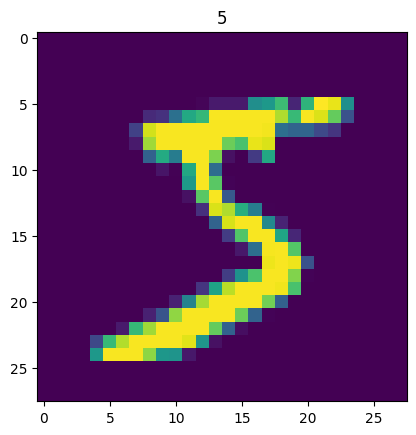

In [5]:
# plot an example
plt.imshow(data_dict['x_train'][0].reshape(28, 28))
plt.title(data_dict['y_train'][0].argmax().item())
plt.show()

In [6]:
import cmd
import numpy as np
from torchmetrics import ConfusionMatrix

def evaluator(y_test, y_pred):
    ####################################################################################################
    # code for evaluation metrics including confusion matrix, accuracy, precision and recall
    # only use Numpy or Pytorch to implement the metrics
            
    cm = ConfusionMatrix(num_classes = 10)
    cm = cm(y_pred, y_test)   #takes parameters in this order: (prediction, target)
    
    cm = cm.cpu().detach().numpy() #convert tensor to numpy array 

    accuracy = torch.sum(y_test == y_pred)/len(y_test)
    precision = np.diag(cm) / np.sum(cm, axis = 0)
    recall = np.diag(cm) / np.sum(cm, axis = 1)
    f1 = (2*precision*recall)/(precision+recall)

    #take average of all the classes 
    print(" EVALUATION METRICS")
    print('Accuracy', accuracy.item())
    print('Precision', precision.mean())
    print('Recall', recall.mean())
    print('F1 Score', f1.mean()) 

    #PRINT CONFUSION MATRIX
    print()
    print("           Confusion Matrix")

    print('actual      [            ]')
    print('              prediction ')

    print(cm)


    # y_pred = y_pred.cpu().detach().numpy()
    # y_test = y_test.cpu().detach().numpy()

    # tp = np.sum(np.logical_and(y_test == 1, y_pred== 1))
    # tn = np.sum(np.logical_and(y_test == 0, y_pred== 0))
    # fp = np.sum(np.logical_and(y_test == 1, y_pred == 0))
    # fn = np.sum(np.logical_and(y_test == 0, y_pred == 1))
    ####################################################################################################

## [Part 1](#Part-1)  

### Build Model1
Use Pytorch to implement a three-layer Neural Network (input layer - hidden layer - output layer) and update the weights with backpropagation  
- 1. Implement forward and calculate the output
- 2. Calculate errors and loss
- 3. Update the weights with backpropagation 
- 4. Predict function
- 5. Activation function (Sigmoid function)

### Evaluator Function
Implement the evaluator function with Pytorch or Numpy only   
- Evaluation metrics include confusion matrix, accuracy, recall score, precision and F1 score

### Train and Evaluate Model1
Train Model1 with customized hidden size, learning rate, number of iterations and batch size  
Use the predict function to predict the labels with the test dataset  
Evaluate the prediction results  
- Evaluation metrics include confusion matrix, accuracy, recall score, precision and F1 score


In [7]:
from cmath import nan
from sys import displayhook
import torch.nn as nn

class NN(object):
    def __init__(self, learning_rate, n_iters, batch_size, hidden_size, device, dtype=torch.float32):
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.device = device
        self.dtype = dtype
        self.history = {}
        self.history['train_acc'], self.history['val_acc'], self.history['loss'] = [], [], []
    
    # 5. activation function
    def sigmoid(self, x):
        ####################################################################################################
        # enter code here to implement the activation function
        return 1/(1+torch.exp(-x))
        ####################################################################################################

    def train(self, x, y, x_val, y_val, verbose=1):
        n_train = x.shape[0]
        n_val = x_val.shape[0]
        input_size = x.shape[1]
        num_classes = y.shape[1]
        
        # weight initialization
        self.W1 = torch.randn(input_size, self.hidden_size, dtype=self.dtype, device=self.device) * 0.01
        self.W2 = torch.randn(self.hidden_size, num_classes, dtype=self.dtype, device=self.device) * 0.01

        # TODO: train the weights with the input data and labels
        for i in range(self.n_iters):
            loss = 0
            data = getBatch(x, y, self.batch_size)
            for x_batch, y_batch in data:
                # 1. forward
                ####################################################################################################
                # code to calculate the hidden layer output and output layer output
                hidden = self.sigmoid(torch.matmul(x_batch, self.W1))
                output = self.sigmoid(torch.matmul(hidden, self.W2))
                ####################################################################################################

                # 2. error and loss
                ####################################################################################################
                # code to calculate the output error, MSE loss, delta output and delta hidden
                # code belows implements the calculation shown in https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/

                output_error = output - y_batch #output - target
                loss_a = output_error.pow(2).mean() #error = sum 1/n(target - out)^2

                #removes NaN error - if value is NaN do not add it to loss sum 
                if loss_a == loss_a:
                     loss += loss_a

                d_o = torch.mul(output_error, (output*(1.0-output))) #outer node delta 
                delta_output = torch.matmul(hidden.T, d_o) #node delta * hidden output

                dh = torch.matmul(d_o, self.W2.T)
                d_h = torch.mul(dh, (hidden*(1.0-hidden)))  #hidden node delta
    
                delta_hidden = torch.matmul(x_batch.T, d_h) #hidden node delta * input 

                ####################################################################################################

                # 3. backward
                ####################################################################################################
                # code to calculate delta weights and update the weights
                self.W1 -= self.learning_rate * delta_hidden
                self.W2 -= self.learning_rate * delta_output
                ####################################################################################################

            # calculate the accuracy and save the training history
            y_pred = self.predict(x)
            train_acc = torch.sum(torch.argmax(y, dim=1) == y_pred) / n_train
            self.history['train_acc'].append(train_acc)
            self.history['loss'].append(loss)
            
            y_pred = self.predict(x_val)
            val_acc = torch.sum(torch.argmax(y_val, dim=1) == y_pred) / n_val
            self.history['val_acc'].append(val_acc)
            if verbose:
                print('epoch %d, loss %.4f, train acc %.3f, validation acc %.3f'
                  % (i + 1, loss, train_acc, val_acc))
    
    # 4. predict function 
    def predict(self, x):
        ####################################################################################################
        # code to implement the predict function
        # TODO: use the trained weights to predict labels and return the predicted labels
        # remember to use torch.argmax() to return the true labels
        hidden = self.sigmoid(torch.matmul(x, self.W1))
        output = self.sigmoid(torch.matmul(hidden, self.W2))
    
        return torch.argmax(output, dim=1) #return true labels
        ####################################################################################################

def getBatch(x, y, batch_size):
    n_epoch = x.shape[0] // batch_size
    for i in range(n_epoch):
        x_batch = x[i * batch_size : (i+1) * batch_size]
        y_batch = y[i * batch_size : (i+1) * batch_size]
        yield x_batch, y_batch
    x_batch = x[(i+1) * batch_size:]
    y_batch = y[(i+1) * batch_size:]    
    yield x_batch, y_batch

In [8]:
####################################################################################################
# enter code here to train Model1
# TODO: set your desired hidden size, learning rate, number of iterations and batch size
# remeber to load the dataset to the device (e.g. data_dict['x_train'].to(device))
model = NN(0.1, 10, 16, 100, device)
model.train(data_dict['x_train'].to(device),
            data_dict['y_train'].to(device),
            data_dict['x_val'].to(device),
            data_dict['y_val'].to(device), 
            verbose=1)

####################################################################################################

epoch 1, loss 72.8811, train acc 0.931, validation acc 0.938
epoch 2, loss 31.2665, train acc 0.953, validation acc 0.956
epoch 3, loss 23.9409, train acc 0.962, validation acc 0.963
epoch 4, loss 19.8536, train acc 0.968, validation acc 0.967
epoch 5, loss 17.1310, train acc 0.973, validation acc 0.969
epoch 6, loss 15.1632, train acc 0.976, validation acc 0.971
epoch 7, loss 13.5934, train acc 0.978, validation acc 0.971
epoch 8, loss 12.2954, train acc 0.980, validation acc 0.972
epoch 9, loss 11.2000, train acc 0.982, validation acc 0.973
epoch 10, loss 10.2676, train acc 0.983, validation acc 0.973


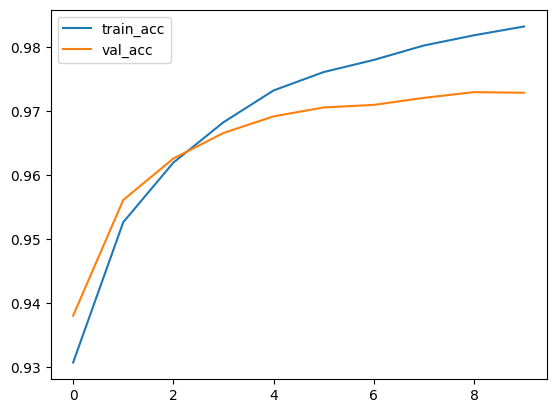

In [9]:
plt.plot(model.history['train_acc'], label='train_acc')
plt.plot(model.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [10]:
####################################################################################################
# enter code here to evaluate Model1 with test set
# TODO: use the trained Model1 to predict the labels of test set and evaluate the results with the evaluator
predict = model.predict(data_dict['x_test'].to(device))
y_test_labels = torch.argmax(data_dict['y_test'].to(device), dim=1)
evaluator(y_test_labels, predict)
####################################################################################################

 EVALUATION METRICS
Accuracy 0.9718000292778015
Precision 0.9720292492124056
Recall 0.9716512460484374
F1 Score 0.9716875127045237

           Confusion Matrix
actual      [            ]
              prediction 
[[ 964    0    1    4    0    3    5    1    2    0]
 [   0 1114    1    7    0    1    2    2    8    0]
 [   5    0 1001    9    2    0    1    7    7    0]
 [   0    0    3  994    0    1    0    6    5    1]
 [   1    0    4    1  965    0    4    1    2    4]
 [   3    0    0   17    1  855    7    1    5    3]
 [   6    2    0    1    1    2  942    0    4    0]
 [   1    6   11    5    1    0    1  993    5    5]
 [   2    0    3    7    5    3    6    3  944    1]
 [   3    6    1   17   18    3    1    8    6  946]]


## [Part 2](#Part-2)  

Use another machine learning framework (**scikit-learn, Tensorflow and Pytorch**) to build MLP
e.g. 
  1. https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
  2. https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
  3. https://pytorch.org/tutorials/beginner/examples_nn/polynomial_nn.html#sphx-glr-beginner-examples-nn-polynomial-nn-py
  
### Build Model2-1
Implement Model2-1 with the same hidden nodes and optimization function as the model in Part 1  
Train and validate model. Use the best model on validation dataset to test on the test dataset  

### Train and Evaluate Model2-1
Evaluate the prediction results  
- Evaluation metrics include confusion matrix, accuracy, recall score, precision and F1 score

### Build Model2-2
Add one more hidden layer (2 hidden layers in total) to the model  
Describe Model2-2 (number of hidden nodes)  
Train and validate model. Use the best model on validation dataset to test on the test dataset  

### Train and Evaluate Model2-2
Evaluate the prediction results  
- Evaluation metrics include confusion matrix, accuracy, recall score, precision and F1 score

### Model2-1

In [11]:
####################################################################################################
# enter code here to implement Model2-1
from pickle import TRUE
from sklearn.neural_network import MLPClassifier
#chose a 2^n batch size 
#small learning rate
#fixed # of epochs

mlp = MLPClassifier(activation = 'logistic',learning_rate_init= 0.1, hidden_layer_sizes= (100,), batch_size = 64, 
                                        early_stopping = True, solver='sgd', max_iter = 10, verbose = True)

######################################################################################################

In [12]:
# enter code here to train Model2-1
####################################################################################################
mlp.fit(data_dict['x_train'], data_dict['y_train']) 
y_prediction1 = mlp.predict(data_dict['x_test'])
# ####################################################################################################

Iteration 1, loss = 0.78507691
Validation score: 0.888400
Iteration 2, loss = 0.37903427
Validation score: 0.918600
Iteration 3, loss = 0.28763333
Validation score: 0.930200
Iteration 4, loss = 0.23487739
Validation score: 0.940200
Iteration 5, loss = 0.19977679
Validation score: 0.943000
Iteration 6, loss = 0.17426288
Validation score: 0.943000
Iteration 7, loss = 0.15277445
Validation score: 0.949200
Iteration 8, loss = 0.13680322
Validation score: 0.944400
Iteration 9, loss = 0.12491563
Validation score: 0.947800
Iteration 10, loss = 0.11227851
Validation score: 0.951400


c:\Users\salvi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


In [13]:
from sklearn.metrics import classification_report, confusion_matrix
####################################################################################################
# enter code here to evaluate Model2-1
print("           CONFUSION MATRIX")
print('actual      [            ]')
print('              prediction ')
print()
cf_matrix = confusion_matrix(data_dict['y_test'].argmax(axis=1), y_prediction1.argmax(axis=1))
print(cf_matrix)
print()
print("                      EVALUATION METRICS")
print(classification_report(data_dict['y_test'].argmax(axis=1), y_prediction1.argmax(axis=1)))
####################################################################################################

           CONFUSION MATRIX
actual      [            ]
              prediction 

[[ 978    0    0    0    0    0    0    1    1    0]
 [  10 1120    1    0    0    1    1    0    2    0]
 [  28    0  998    1    0    0    0    3    2    0]
 [  25    0   11  967    0    0    0    2    4    1]
 [  27    0    5    0  928    0    2    1    2   17]
 [  32    1    1   12    0  839    3    1    3    0]
 [  30    3    0    0    3    2  918    0    2    0]
 [  22    5   12    3    1    0    0  979    0    6]
 [  20    0    5    7    3    5    1    3  930    0]
 [  45    6    1    5    3    2    0    4    7  936]]

                      EVALUATION METRICS
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.97      0.96      0.96      1010
           4       0.99      0.95      0.97       982
           5       0

### Model2-2

In [14]:
####################################################################################################
# enter code here to implement Model2-2
from pickle import TRUE
from sklearn.neural_network import MLPClassifier
#two hidden layers 
mlp2 = MLPClassifier(activation = 'logistic',learning_rate_init= 0.1, hidden_layer_sizes = (100, 50), batch_size = 64, 
                                        early_stopping = True, solver='sgd', max_iter = 10, verbose = True)
####################################################################################################

In [15]:
####################################################################################################
# enter code here to train Model2-2
mlp2.fit(data_dict['x_train'], data_dict['y_train']) 
y_prediction2 = mlp2.predict(data_dict['x_test'])
####################################################################################################

Iteration 1, loss = 1.22279900
Validation score: 0.885600
Iteration 2, loss = 0.39561546
Validation score: 0.922400
Iteration 3, loss = 0.27364479
Validation score: 0.939600
Iteration 4, loss = 0.20850655
Validation score: 0.951200
Iteration 5, loss = 0.17093354
Validation score: 0.954200
Iteration 6, loss = 0.14398655
Validation score: 0.948800
Iteration 7, loss = 0.12392409
Validation score: 0.955600
Iteration 8, loss = 0.10333955
Validation score: 0.962400
Iteration 9, loss = 0.08954004
Validation score: 0.955800
Iteration 10, loss = 0.07783621
Validation score: 0.962000


c:\Users\salvi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


In [16]:
####################################################################################################
# enter code here to evaluate Model2-2
from sklearn.metrics import classification_report, confusion_matrix

print("           CONFUSION MATRIX")
print('actual      [            ]')
print('              prediction ')
print()
cf_matrix = confusion_matrix(data_dict['y_test'].argmax(axis=1), y_prediction2.argmax(axis=1))
print(cf_matrix)
print()
print("                      EVALUATION METRICS")
print(classification_report(data_dict['y_test'].argmax(axis=1), y_prediction2.argmax(axis=1)))
####################################################################################################



           CONFUSION MATRIX
actual      [            ]
              prediction 

[[ 967    0    0    1    2    2    6    1    1    0]
 [   5 1126    0    0    0    1    1    0    2    0]
 [  27    1  990    3    1    0    2    4    4    0]
 [  17    1    2  980    0    1    0    4    3    2]
 [  13    0    1    0  946    0    5    0    1   16]
 [  22    1    0    5    0  853    5    1    4    1]
 [  11    3    1    0    2    4  933    0    4    0]
 [  18    5    7    5    0    0    0  987    0    6]
 [  22    1    1    4    2    6    2    3  931    2]
 [  19    4    0    9    5    4    1    6    4  957]]

                      EVALUATION METRICS
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.96      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.99      0.96      0.98       982
           5       0